In [2]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

2021-12-26 14:07:22.722001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-26 14:07:22.722065: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#load data
company = 'FB'

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = web.DataReader(company, 'yahoo', start, end)


In [4]:
#prepare date
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [5]:
#build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #perdiction of the next close

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



2021-12-26 14:07:31.181521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-26 14:07:31.182125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-26 14:07:31.182416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-26 14:07:31.182778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-26 14:07:31.183055: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/25
59/59 [==============================] - 20s 186ms/step - loss: 0.0260
Epoch 2/25
59/59 [==============================] - 11s 185ms/step - loss: 0.0055
Epoch 3/25
59/59 [==============================] - 12s 195ms/step - loss: 0.0042
Epoch 4/25
59/59 [==============================] - 11s 189ms/step - loss: 0.0038
Epoch 5/25
59/59 [==============================] - 11s 183ms/step - loss: 0.0032
Epoch 6/25
59/59 [==============================] - 11s 190ms/step - loss: 0.0033
Epoch 7/25
59/59 [==============================] - 13s 220ms/step - loss: 0.0033
Epoch 8/25
59/59 [==============================] - 11s 184ms/step - loss: 0.0034
Epoch 9/25
59/59 [==============================] - 11s 184ms/step - loss: 0.0028
Epoch 10/25
59/59 [==============================] - 11s 185ms/step - loss: 0.0033
Epoch 11/25
59/59 [==============================] - 11s 186ms/step - loss: 0.0027
Epoch 12/25
59/59 [==============================] - 11s 183ms/step - loss: 0.0026
Epoch 13/25
5

In [6]:
#test the model accuracy on existing data

#load test data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)- len(test_data) - prediction_days :].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [7]:
#make perdictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days: x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


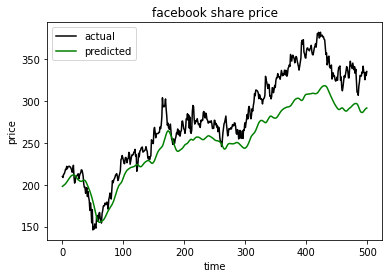

In [8]:
#plot the test perdicitons
plt.plot(actual_prices, color='black', label='actual')
plt.plot(predicted_prices, color='green', label='predicted')
plt.title('facebook share price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [18]:
#predict next day
real_data = [model_inputs[len(model_inputs + 1)  - prediction_days:len(model_inputs + 1), 0]]
print(len(model_inputs +1))
real_data = np.array(real_data)
print(real_data.shape)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f"Prediction: {prediction}")
print(f"Prediction: {prediction[0][0]}")

560
(1, 60)
Prediction: [[292.04077]]
Prediction: 292.040771484375


In [15]:
import pickle
import joblib
filename = "stock_model.pkl"
joblib.dump(model, filename)

2021-12-26 14:31:02.292394: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://a34ba069-d8e6-4749-971f-43c7e5dfc228/assets


INFO:tensorflow:Assets written to: ram://a34ba069-d8e6-4749-971f-43c7e5dfc228/assets


['stock_model.pkl']